In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '81-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 12,
  "LEARNING_RATE": 0.00000125 * REPLICAS * 256,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 10,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-384x384',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 384,
 'LEARNING_RATE': 0.00256,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 10,
 'WIDTH': 384}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-3c0c447892078c6cb0cb069958214c9fedc65fe9efc33682fef72a3e'
TRAINING_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
TEST_FILENAMES = np.sort(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .4: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .4: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])
        
    if p_pixel >= .3: # Pixel-level transforms
      if p_pixel >= .8:
        image['input_image'] = data_augment_hue(image['input_image'])
      elif p_pixel >= .6:
        image['input_image'] = data_augment_saturation(image['input_image'])
      elif p_pixel >= .4:
        image['input_image'] = data_augment_contrast(image['input_image'])
      else:
        image['input_image'] = data_augment_brightness(image['input_image'])

    if p_rotation >= .4: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    if p_cutout >= .4: # Cutout
      image['input_image'] = data_augment_cutout(image['input_image'])
    
    return image, label


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_tfrecord(example, labeled=False, return_names=False, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    if labeled:
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        label = tf.cast(example['target'], tf.float32)
    else:
        example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    if return_names:
        image_name = example['image_name']

    image = decode_image(example['image'], height, width, channels)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    if labeled:
        if return_names:
            return {'input_image': image, 'input_meta': data}, label, image_name
        else:
            return {'input_image': image, 'input_meta': data}, label
    else:
        if return_names:
            return {'input_image': image, 'input_meta': data}, image_name
        else:
            return {'input_image': image, 'input_meta': data}

def load_dataset(filenames, labeled=False, return_names=False, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size)
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_tfrecord(example, labeled, return_names), num_parallel_calls=buffer_size)   
    return dataset

def get_dataset(filenames, labeled=True, return_names=False, ordered=False, repeated=False, augment=False, 
                batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, labeled, return_names, ordered, buffer_size)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=buffer_size)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00256 to 0.000671


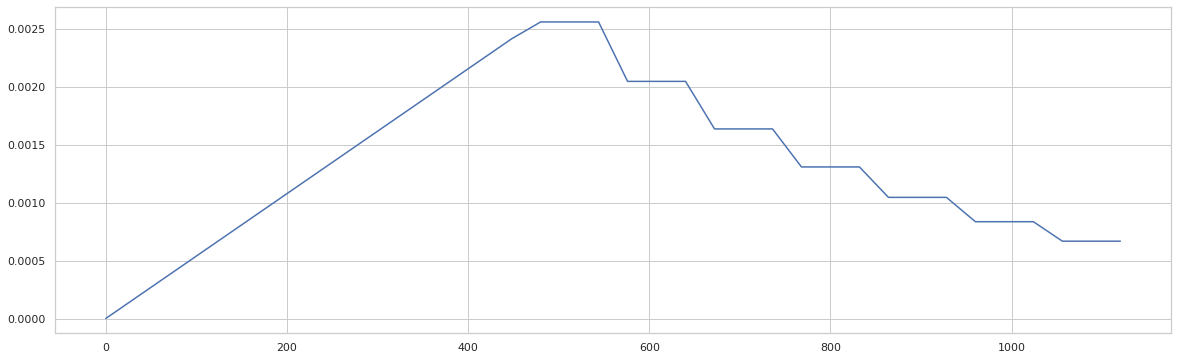

In [11]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24519 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_TRAIN_IMAGES = count_data_items(TRAINING_FILENAMES)
# Evaluation
eval_dataset = get_dataset(TRAINING_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=False, 
                           batch_size=1024, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TRAIN_IMAGES))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, image_name: data)

# Test
test_preds = np.zeros((NUM_TEST_IMAGES, 1)); test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, return_names=True, ordered=True, repeated=False, augment=True, 
                           batch_size=1024, buffer_size=AUTO)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)

# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]
k_fold_best = k_fold.copy()

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
            
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])
            
        history = model.fit(get_dataset(train_filenames, labeled=True, return_names=False, ordered=False, repeated=True, 
                                        augment=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_dataset(valid_filenames, labeled=True, return_names=False, ordered=True, 
                                                        repeated=False, augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[checkpoint],
                            verbose=2).history

        history_list.append(history)

        # Save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        # Get validation IDs
        valid_dataset = get_dataset(valid_filenames, labeled=False, return_names=True, ordered=True, repeated=False, 
                                    augment=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print(f'Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print(f'Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/12
102/102 - 159s - loss: 0.1739 - auc: 0.7065 - val_loss: 0.1736 - val_auc: 0.7344
Epoch 2/12
102/102 - 131s - loss: 0.1686 - auc: 0.7975 - val_loss: 0.1723 - val_auc: 0.8431
Epoch 3/12
102/102 - 124s - loss: 0.1684 - auc: 0.8193 - val_loss: 0.1740 - val_auc: 0.6151
Epoch 4/12
102/102 - 131s - loss: 0.1679 - auc: 0.8429 - val_loss: 0.1705 - val_auc: 0.8326
Epoch 5/12
102/102 - 125s - loss: 0.1676 - auc: 0.8289 - val_loss: 0.1763 - val_auc: 0.6837
Epoch 6/12
102/102 - 124s - loss: 0.1688 - auc: 0.8028 - val_loss: 0.1757 - val_auc: 0.7885
Epoch 7/12
102/102 - 125s - loss: 0.1657 - auc: 0.8549 - val_loss: 0.1724 - val_auc: 0.7878
Epoch 8/12
102/102 - 131s - loss: 0.1657 - auc: 0.8564 - val_loss: 0.1684 - val_auc: 0.8490
Epoch 9/12
102/102 - 131s - loss: 0.1632 - auc: 0.8874 - val_loss: 0.1648 - val_auc: 0.8729
Epoch 10/12
102/102 - 125s - loss: 0.1625 - auc: 0.8920 - val_loss: 0.1676 - val_auc: 0.8737
Epoch 11/12


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 163s - loss: 0.1738 - auc: 0.7008 - val_loss: 0.1783 - val_auc: 0.6880
Epoch 2/12
102/102 - 131s - loss: 0.1704 - auc: 0.7890 - val_loss: 0.1735 - val_auc: 0.8083
Epoch 3/12
102/102 - 130s - loss: 0.1673 - auc: 0.8265 - val_loss: 0.1716 - val_auc: 0.7943
Epoch 4/12
102/102 - 125s - loss: 0.1677 - auc: 0.8286 - val_loss: 1.5169 - val_auc: 0.7706
Epoch 5/12
102/102 - 125s - loss: 0.1691 - auc: 0.8082 - val_loss: 32.0557 - val_auc: 0.5444
Epoch 6/12
102/102 - 125s - loss: 0.1682 - auc: 0.8213 - val_loss: 1.4695 - val_auc: 0.3397
Epoch 7/12
102/102 - 131s - loss: 0.1670 - auc: 0.8453 - val_loss: 0.1705 - val_auc: 0.8130
Epoch 8/12
102/102 - 131s - loss: 0.1655 - auc: 0.8662 - val_loss: 0.1662 - val_auc: 0.8593
Epoch 9/12
102/102 - 125s - loss: 0.1640 - auc: 0.8909 - val_loss: 0.1662 - val_auc: 0.8585
Epoch 10/12
102/102 - 125s - loss: 0.1626 - auc: 0.8894 - val_loss: 0.1680 - val_auc: 0.8639
Epoch 11/12
102/102 - 131s - loss: 0.1609 - auc: 0.9146 - val_loss: 0.1659 - v

INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 161s - loss: 0.1741 - auc: 0.6820 - val_loss: 0.1770 - val_auc: 0.6024
Epoch 2/12
102/102 - 126s - loss: 0.1709 - auc: 0.7978 - val_loss: 0.1805 - val_auc: 0.7821
Epoch 3/12
102/102 - 131s - loss: 0.1687 - auc: 0.7930 - val_loss: 0.1750 - val_auc: 0.6677
Epoch 4/12
102/102 - 131s - loss: 0.1696 - auc: 0.7825 - val_loss: 0.1733 - val_auc: 0.7004
Epoch 5/12
102/102 - 125s - loss: 0.1698 - auc: 0.7801 - val_loss: 0.1903 - val_auc: 0.6577
Epoch 6/12
102/102 - 132s - loss: 0.1696 - auc: 0.7953 - val_loss: 0.1707 - val_auc: 0.8080
Epoch 7/12
102/102 - 132s - loss: 0.1682 - auc: 0.8285 - val_loss: 0.1693 - val_auc: 0.8274
Epoch 8/12
102/102 - 125s - loss: 0.1663 - auc: 0.8540 - val_loss: 0.2464 - val_auc: 0.8769
Epoch 9/12
102/102 - 131s - loss: 0.1646 - auc: 0.8789 - val_loss: 0.1685 - val_auc: 0.8532
Epoch 10/12
102/102 - 131s - loss: 0.1630 - auc: 0.8801 - val_loss: 0.1648 - val_auc: 0.8804
Epoch 11/12
102/102 - 125s - loss: 0.1629 - auc: 0.8827 - val_loss: 0.1665 - va

INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 162s - loss: 0.1742 - auc: 0.7051 - val_loss: 0.1838 - val_auc: 0.5776
Epoch 2/12
102/102 - 132s - loss: 0.1682 - auc: 0.8100 - val_loss: 0.1707 - val_auc: 0.8180
Epoch 3/12
102/102 - 125s - loss: 0.1678 - auc: 0.8189 - val_loss: 0.1808 - val_auc: 0.6884
Epoch 4/12
102/102 - 125s - loss: 0.1696 - auc: 0.8068 - val_loss: 0.1921 - val_auc: 0.8009
Epoch 5/12
102/102 - 125s - loss: 0.1689 - auc: 0.8141 - val_loss: 0.1887 - val_auc: 0.6850
Epoch 6/12
102/102 - 125s - loss: 0.1690 - auc: 0.8042 - val_loss: 0.1732 - val_auc: 0.7545
Epoch 7/12
102/102 - 132s - loss: 0.1670 - auc: 0.8432 - val_loss: 0.1673 - val_auc: 0.8677
Epoch 8/12
102/102 - 132s - loss: 0.1652 - auc: 0.8547 - val_loss: 0.1659 - val_auc: 0.8673
Epoch 9/12
102/102 - 131s - loss: 0.1642 - auc: 0.8673 - val_loss: 0.1655 - val_auc: 0.8889
Epoch 10/12
102/102 - 131s - loss: 0.1618 - auc: 0.8911 - val_loss: 0.1649 - val_auc: 0.8840
Epoch 11/12
102/102 - 125s - loss: 0.1610 - auc: 0.9021 - val_loss: 0.1650 - va

INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.26.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
102/102 - 162s - loss: 0.1739 - auc: 0.6928 - val_loss: 0.1754 - val_auc: 0.7009
Epoch 2/12
102/102 - 131s - loss: 0.1678 - auc: 0.8228 - val_loss: 0.1706 - val_auc: 0.8054
Epoch 3/12
102/102 - 125s - loss: 0.1710 - auc: 0.7908 - val_loss: 0.1725 - val_auc: 0.6936
Epoch 4/12
102/102 - 125s - loss: 0.1694 - auc: 0.7881 - val_loss: 1.6076 - val_auc: 0.7370
Epoch 5/12
102/102 - 125s - loss: 0.1703 - auc: 0.7999 - val_loss: 7.4587 - val_auc: 0.7605
Epoch 6/12
102/102 - 125s - loss: 0.1685 - auc: 0.8267 - val_loss: 0.1907 - val_auc: 0.7488
Epoch 7/12
102/102 - 132s - loss: 0.1659 - auc: 0.8453 - val_loss: 0.1682 - val_auc: 0.8578
Epoch 8/12
102/102 - 132s - loss: 0.1663 - auc: 0.8673 - val_loss: 0.1659 - val_auc: 0.8442
Epoch 9/12
102/102 - 125s - loss: 0.1635 - auc: 0.8828 - val_loss: 0.1660 - val_auc: 0.8668
Epoch 10/12
102/102 - 125s - loss: 0.1638 - auc: 0.8926 - val_loss: 0.1684 - val_auc: 0.7978
Epoch 11/12
102/102 - 125s - loss: 0.1596 - auc: 0.9038 - val_loss: 0.1777 - va

## Model loss graph

Fold: 1


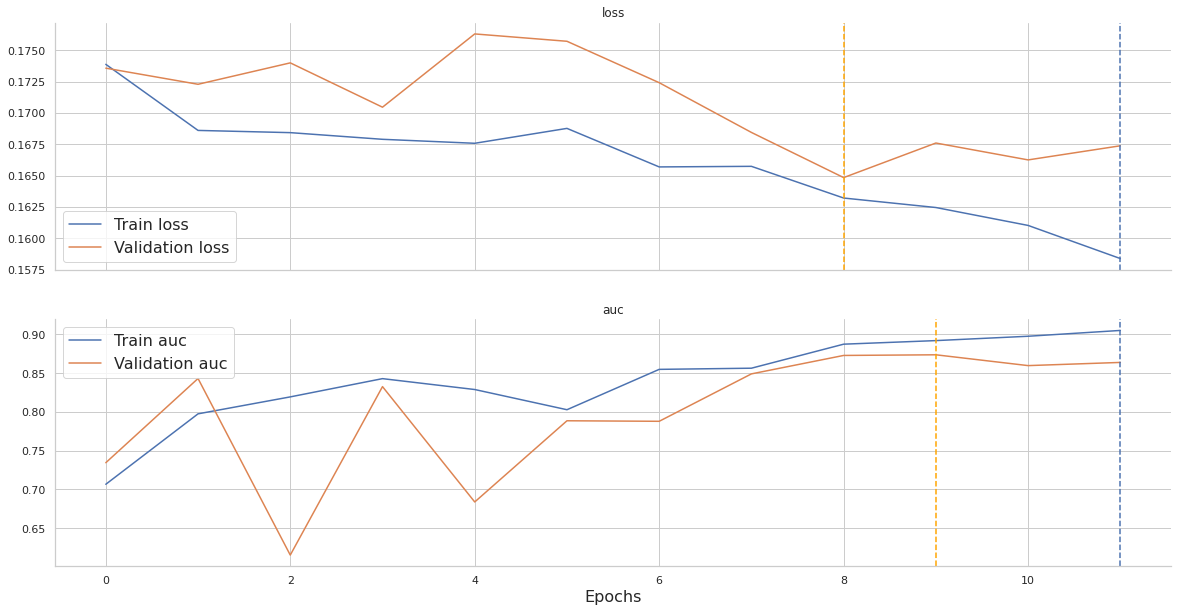

Fold: 2


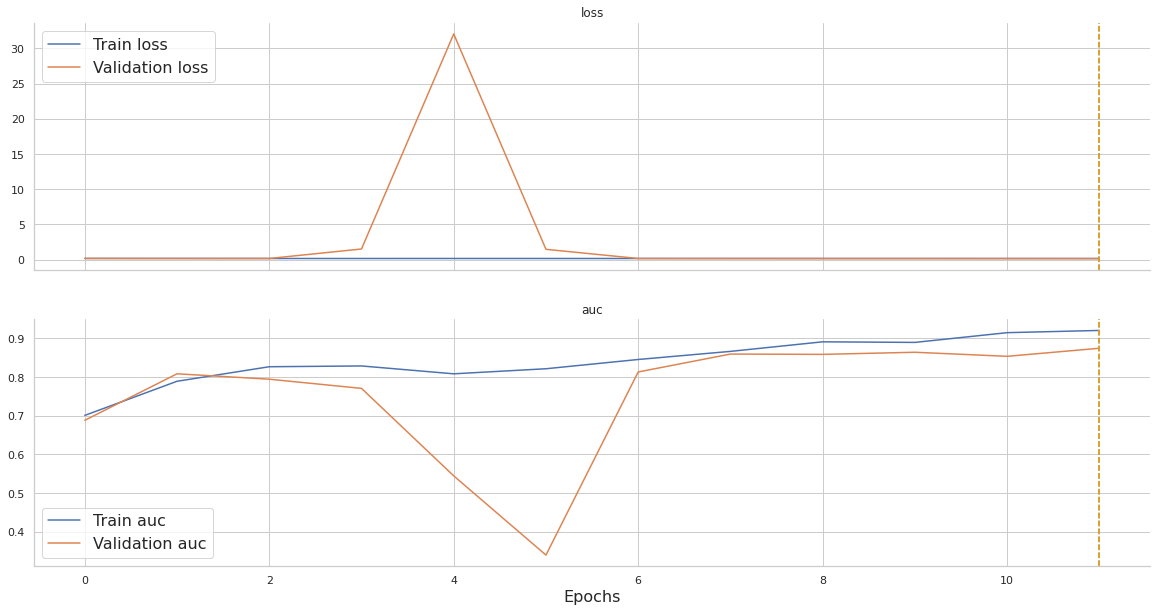

Fold: 3


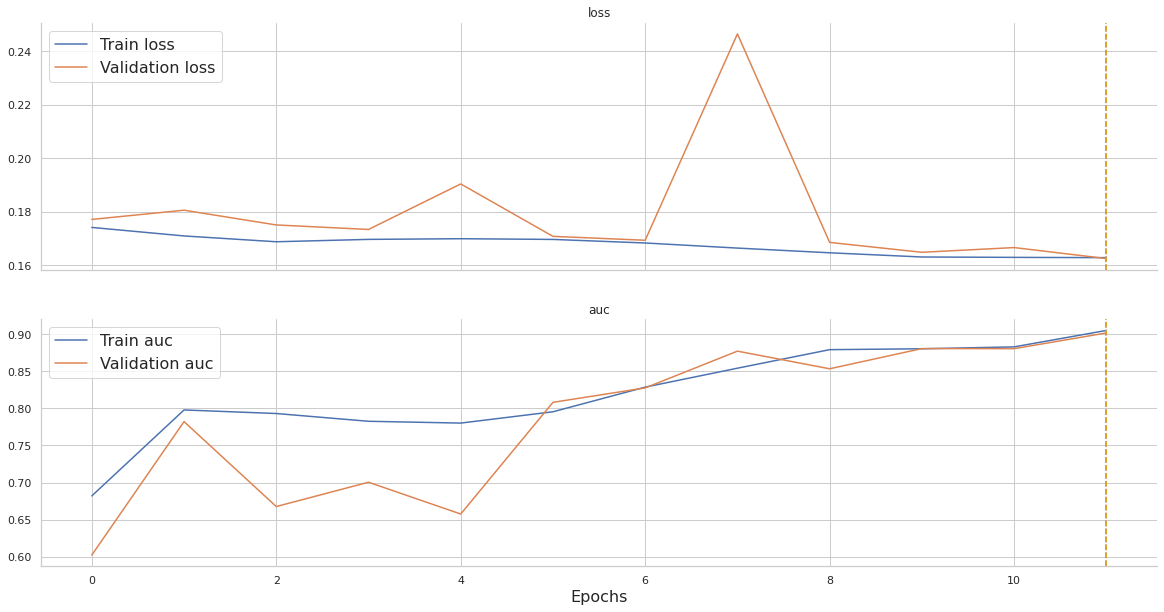

Fold: 4


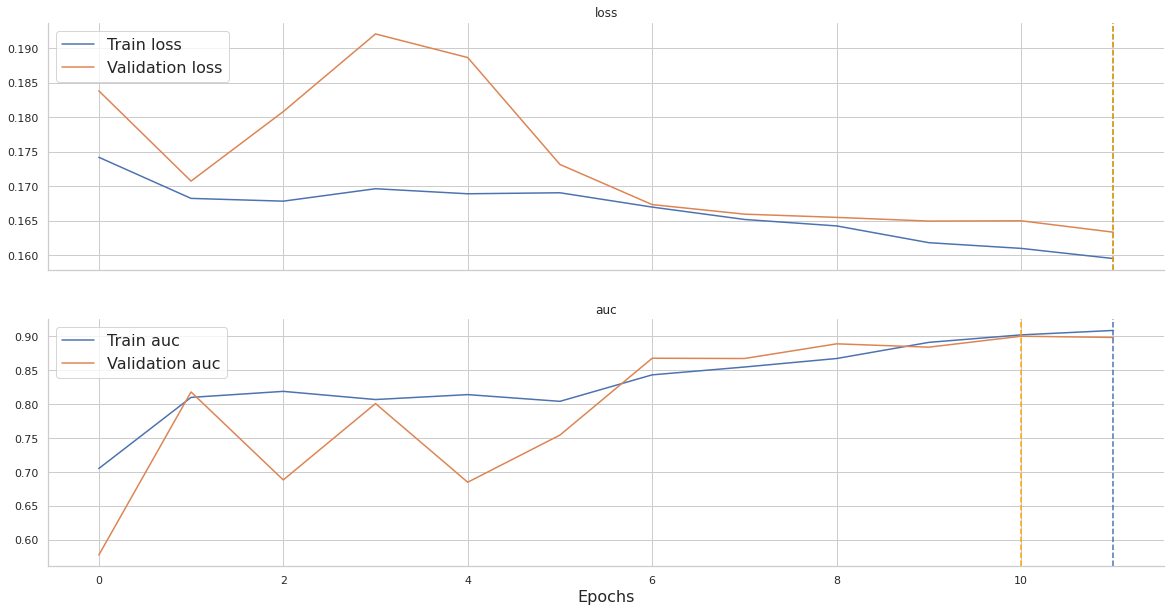

Fold: 5


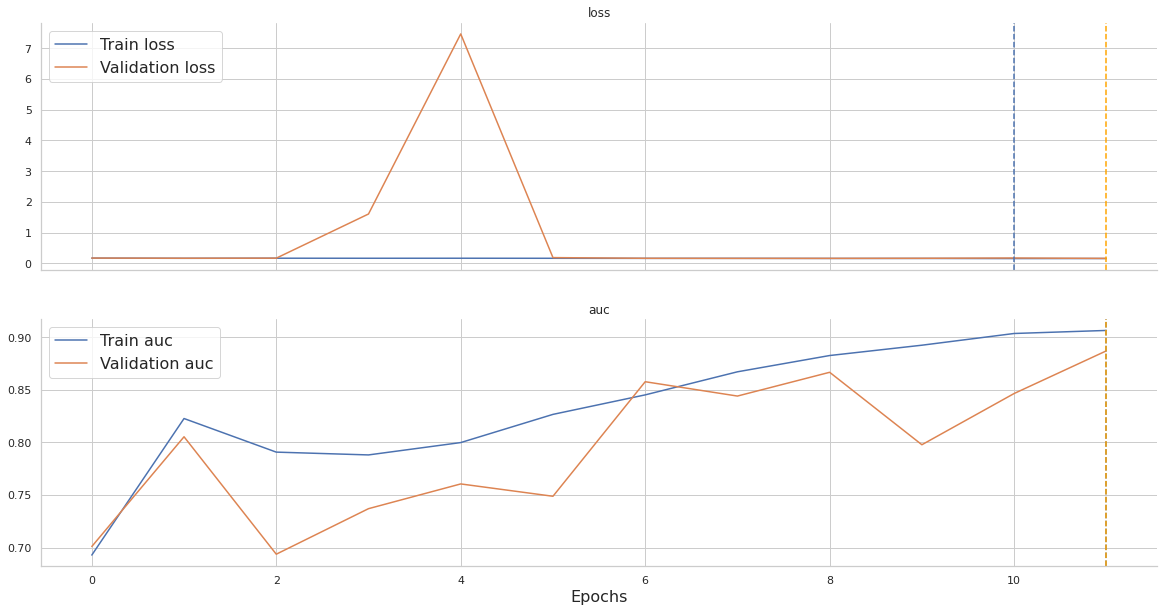

In [15]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

In [16]:
#@title
# plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [17]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.941243,0.892399,0.048845,0.916400,0.872525,0.950224,0.883645,0.940523,0.906305,0.951192,0.907438,0.947876,0.892079
Accuracy,0.983199,0.982228,0.000971,0.982834,0.982252,0.984173,0.981175,0.982632,0.982601,0.983535,0.982655,0.982821,0.982456
Precision,0.804372,0.611096,0.193276,0.863636,0.500000,0.747573,0.294118,0.866667,1.000000,0.869565,0.636364,0.674419,0.625000
Recall,0.076586,0.034409,0.042177,0.040860,0.008621,0.165591,0.043103,0.027957,0.017241,0.086022,0.060345,0.062500,0.042735
F1-score,0.134855,0.063254,0.071601,0.078029,0.016949,0.271127,0.075188,0.054167,0.033898,0.156556,0.110236,0.114398,0.080000
Support,464.800000,116.200000,348.600000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,464.000000,117.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.941243,0.892399,0.048845,0.916400,0.872525,0.950224,0.883645,0.940523,0.906305,0.951192,0.907438,0.947876,0.892079
male,0.946365,0.893609,0.052757,0.921821,0.875074,0.951728,0.906118,0.950705,0.895624,0.953846,0.894266,0.953726,0.896962
female,0.930971,0.883374,0.047598,0.903656,0.869157,0.946445,0.836350,0.921241,0.911817,0.945562,0.922058,0.937953,0.877487
head/neck,0.930921,0.831780,0.099141,0.910829,0.796476,0.933535,0.885965,0.921141,0.799564,0.945607,0.827418,0.943491,0.849476
upper extremity,0.941514,0.908562,0.032952,0.918245,0.897653,0.957620,0.901727,0.941283,0.917002,0.947020,0.920398,0.943403,0.906030
lower extremity,0.915878,0.853687,0.062190,0.867387,0.818470,0.921311,0.839931,0.938680,0.843307,0.925956,0.883549,0.926054,0.883180
torso,0.953008,0.914402,0.038605,0.932502,0.909209,0.962864,0.896646,0.944022,0.943321,0.963904,0.922256,0.961746,0.900579
0 <= age < 26,0.909732,0.827436,0.082296,0.872399,0.786348,0.914060,0.850000,0.922064,0.719124,0.916339,0.867840,0.923798,0.913869
26 <= age < 40,0.916547,0.824822,0.091725,0.861839,0.700678,0.932242,0.835425,0.921228,0.816535,0.930987,0.898984,0.936436,0.872486


# Model evaluation (last)

In [18]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.945183,0.891831,0.053352,0.936163,0.869038,0.950368,0.883736,0.940481,0.907064,0.951192,0.907290,0.947709,0.892027
Accuracy,0.983413,0.981892,0.001522,0.983942,0.979957,0.984211,0.981481,0.982594,0.982601,0.983459,0.982962,0.982860,0.982456
Precision,0.765146,0.581566,0.183581,0.659574,0.222222,0.754902,0.333333,0.857143,1.000000,0.863636,0.727273,0.690476,0.625000
Recall,0.107124,0.044754,0.062370,0.200000,0.051724,0.165591,0.043103,0.025806,0.017241,0.081720,0.068966,0.062500,0.042735
F1-score,0.178515,0.080027,0.098488,0.306931,0.083916,0.271605,0.076336,0.050104,0.033898,0.149312,0.125984,0.114625,0.080000
Support,464.800000,116.200000,348.600000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,465.000000,116.000000,464.000000,117.000000


# Confusion matrix

Fold: 1


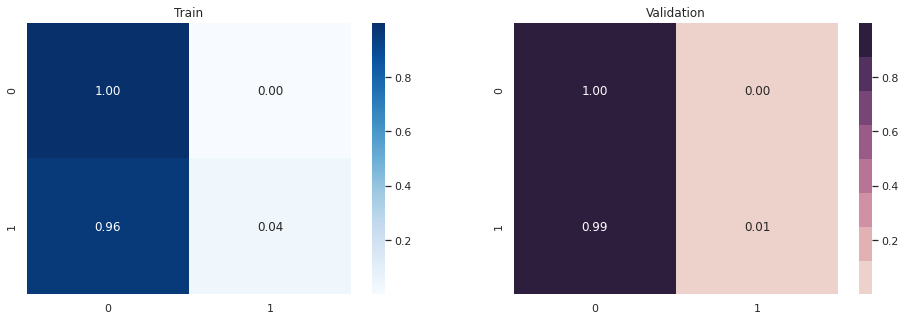

Fold: 2


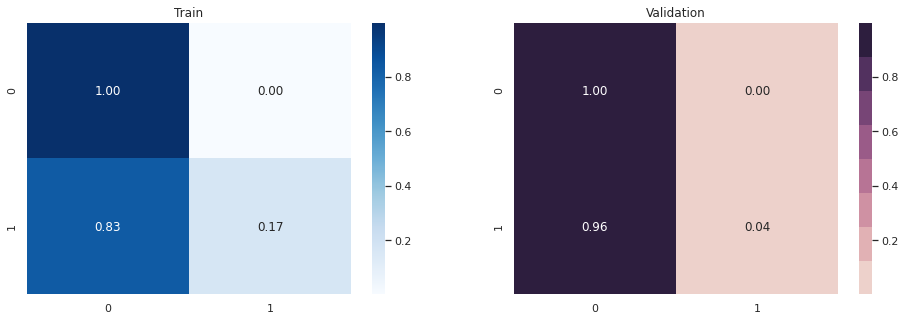

Fold: 3


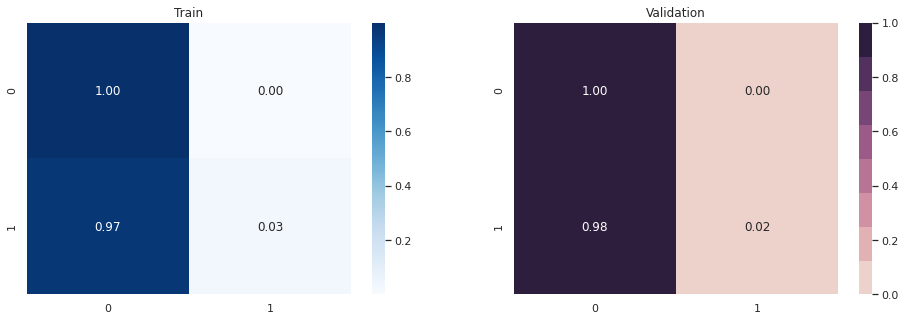

Fold: 4


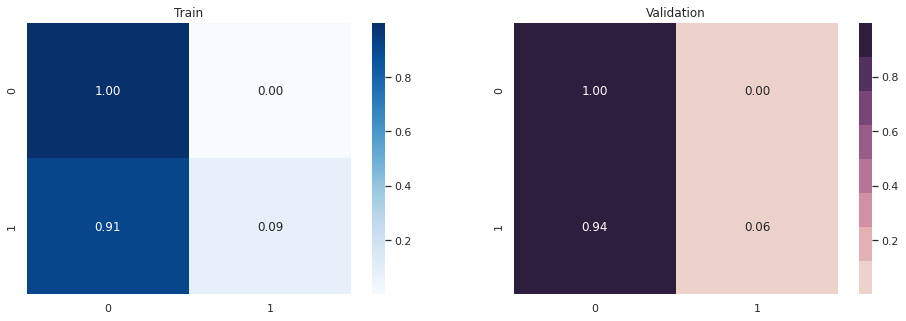

Fold: 5


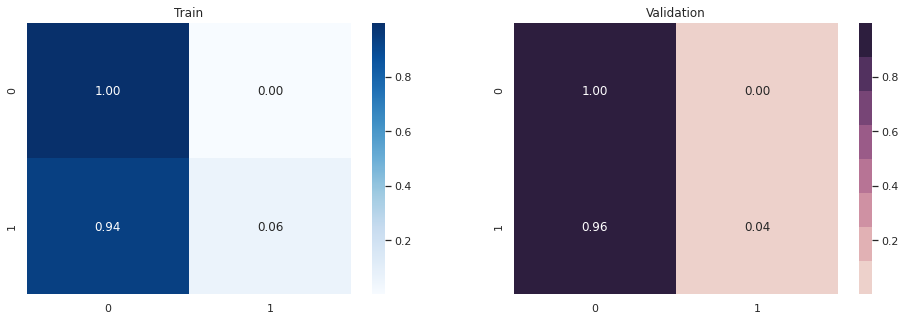

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 44
Train positive correct predictions: 40
Top 5 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.026022,0.026841,0.024729,0.027034,0.023082,0.027777,0.027489
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.025002,0.024841,0.026151,0.023876,0.023623,0.026185,0.025174
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.027124,0.025321,0.038623,0.025039,0.022563,0.024488,0.024906
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.026951,0.028546,0.025482,0.023650,0.030862,0.026098,0.028661
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.023708,0.024055,0.024023,0.022560,0.022510,0.024775,0.024672


Top 5 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.027722,0.027962,0.029803,0.026658,0.025916,0.029557,0.026675
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.229006,0.158982,0.562276,0.091418,0.144392,0.250655,0.096290
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.093449,0.060486,0.208460,0.130910,0.028575,0.071109,0.028192
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.078982,0.081962,0.039311,0.131191,0.038981,0.065511,0.119918
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.163180,0.112943,0.365677,0.178722,0.122870,0.116743,0.031888


Top 5 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_best,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.518178,0.418324,0.840000,0.767211,0.091228,0.455386,0.437063
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.605093,0.606054,0.988412,0.660713,0.528971,0.681993,0.165377
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.587274,0.454923,0.837777,0.593579,0.633707,0.029937,0.841372
4567,ISIC_1473522,female,75.0,torso,melanoma,1,0.559784,0.461172,0.680784,0.641532,0.218287,0.651457,0.606858
5440,ISIC_1728564,male,60.0,lower extremity,melanoma,1,0.718231,0.661544,0.984689,0.987772,0.328358,0.479018,0.811318


,age_approx,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5,pred,pred_best
count,32648.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000,32692.000000
mean,48.812485,0.017772,0.041847,0.039177,0.033849,0.036638,0.035645,0.037431,0.036869
std,14.393434,0.132124,0.061472,0.057558,0.029886,0.042403,0.037638,0.040151,0.035361
min,0.000000,0.000000,0.020622,0.018624,0.017957,0.019235,0.016505,0.020828,0.021119
25%,40.000000,0.000000,0.025904,0.023684,0.023725,0.024836,0.025728,0.025285,0.025140
50%,50.000000,0.000000,0.029044,0.025106,0.026089,0.026989,0.027958,0.027542,0.027367
75%,60.000000,0.000000,0.036429,0.029782,0.032228,0.031759,0.033261,0.033549,0.034039
max,90.000000,1.000000,0.997943,0.996533,0.730303,0.909910,0.937749,0.869686,0.877004


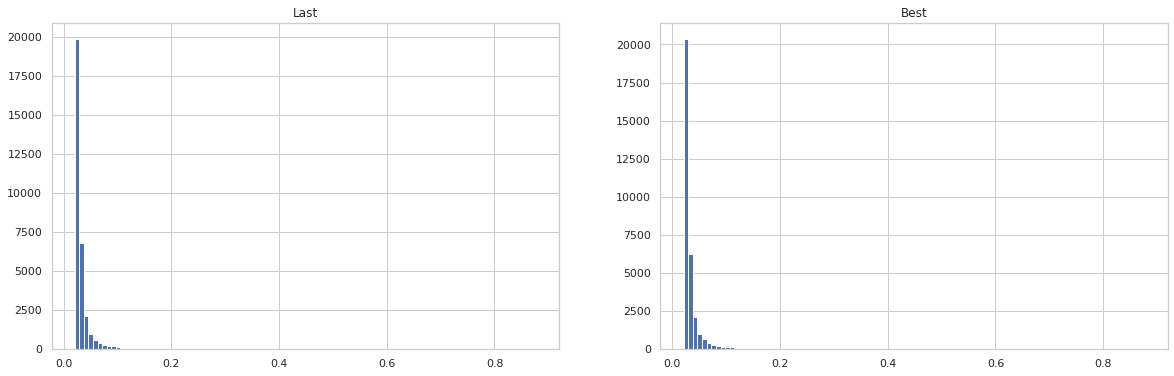

In [20]:
#@title
k_fold['pred'] = 0
k_fold_best['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_USED_FOLDS']
    k_fold_best['pred'] += k_fold_best[f'pred_fold_{n_fold+1}'] / config['N_USED_FOLDS']

k_fold['pred_best'] = k_fold_best['pred']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 5 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(5))

print('Top 5 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(5))

print('Top 5 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred', 'pred_best'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(5))

display(k_fold.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 6))
ax1.hist(k_fold['pred'], bins=100)
ax2.hist(k_fold['pred_best'], bins=100)
ax1.set_title('Last')
ax2.set_title('Best')
plt.show()

# Visualize test predictions

Test predictions 6|10976
Test predictions (last) 10|10972
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.029162,0.029380
1,ISIC_0052349,male,40.0,lower extremity,0.023336,0.024381
2,ISIC_0058510,female,55.0,torso,0.025823,0.025458
3,ISIC_0073313,female,50.0,torso,0.024196,0.023569
4,ISIC_0073502,female,45.0,lower extremity,0.033726,0.029604
5,ISIC_0074618,male,50.0,lower extremity,0.029333,0.029071
6,ISIC_0076801,male,45.0,upper extremity,0.028113,0.027811
7,ISIC_0077586,male,50.0,lower extremity,0.034994,0.032464
8,ISIC_0082004,female,45.0,torso,0.036290,0.031986
9,ISIC_0082785,male,65.0,lower extremity,0.027335,0.028997


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
1408,ISIC_1364884,female,35.0,upper extremity,0.652831,0.665744
3178,ISIC_2976697,female,45.0,torso,0.578816,0.676929
5424,ISIC_4975524,male,75.0,torso,0.521064,0.638201
7651,ISIC_6940742,male,35.0,torso,0.532398,0.684601
7980,ISIC_7233451,female,45.0,torso,0.520598,0.604356
10448,ISIC_9495534,female,35.0,upper extremity,0.657870,0.719994


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
1408,ISIC_1364884,female,35.0,upper extremity,0.652831,0.665744
2116,ISIC_2002073,male,40.0,upper extremity,0.426241,0.503587
3045,ISIC_2839742,male,70.0,upper extremity,0.458428,0.527462
3178,ISIC_2976697,female,45.0,torso,0.578816,0.676929
5424,ISIC_4975524,male,75.0,torso,0.521064,0.638201
7651,ISIC_6940742,male,35.0,torso,0.532398,0.684601
7980,ISIC_7233451,female,45.0,torso,0.520598,0.604356
8061,ISIC_7301931,female,65.0,upper extremity,0.389716,0.543723
10448,ISIC_9495534,female,35.0,upper extremity,0.657870,0.719994
10719,ISIC_9752088,female,60.0,lower extremity,0.411877,0.516799


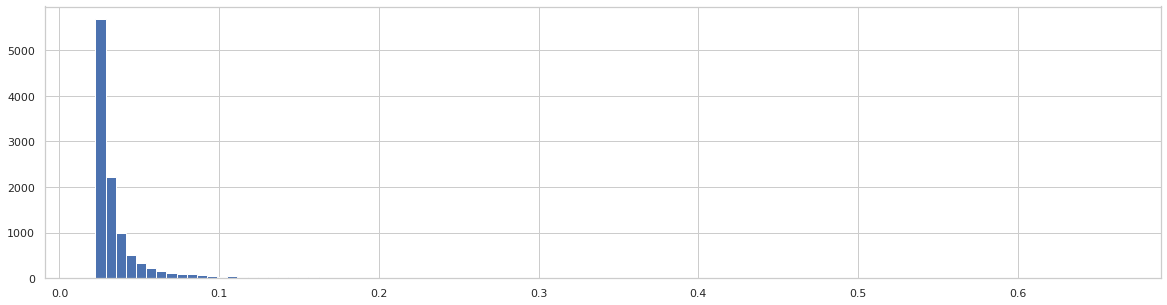

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(test['target'], bins=100)
plt.show()

# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.029162,0.029380,0.029271
1,ISIC_0052349,0.023336,0.024381,0.023859
2,ISIC_0058510,0.025823,0.025458,0.025640
3,ISIC_0073313,0.024196,0.023569,0.023883
4,ISIC_0073502,0.033726,0.029604,0.031665
5,ISIC_0074618,0.029333,0.029071,0.029202
6,ISIC_0076801,0.028113,0.027811,0.027962
7,ISIC_0077586,0.034994,0.032464,0.033729
8,ISIC_0082004,0.036290,0.031986,0.034138
9,ISIC_0082785,0.027335,0.028997,0.028166


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.038984,0.039157,0.039070
std,0.036130,0.040640,0.038228
min,0.022508,0.022108,0.022399
25%,0.025475,0.025385,0.025467
50%,0.028593,0.028019,0.028361
75%,0.036813,0.035361,0.036071
max,0.657870,0.719994,0.688932
